# Load and check model

In [1]:
import requests
# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [2]:
import torch
# torch.multiprocessing.set_start_method("spawn")
import torch.nn as nn
from torchvision.models import resnet101
import torch.nn.functional as F
import torchvision

import albumentations as A
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Wed Aug  7 16:43:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 25%   35C    P8     8W / 250W |   3307MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 20%   42C    P8     9W / 250W |      1MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [5]:
model = resnet101(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg'

--2019-07-27 20:31:13--  https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789779 (771K) [image/jpeg]
Saving to: ‘An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg.7’

An_up-close_picture 100%[===================>] 771.27K  2.64MB/s    in 0.3s    

2019-07-27 20:31:14 (2.64 MB/s) - ‘An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg.7’ saved [789779/789779]



In [7]:
image = cv2.imread('An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image

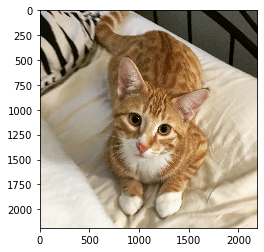

In [8]:
plt.imshow(image)

In [9]:
preprocess = A.Compose([A.Normalize(max_pixel_value=255.0),A.Resize(400,400)])
preprocess

Compose([
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
  Resize(always_apply=False, p=1, height=400, width=400, interpolation=1),
], p=1.0, bbox_params={}, keypoint_params={}, additional_targets={})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


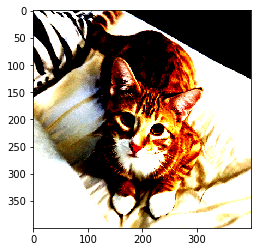

In [10]:
plt.imshow(preprocess(image=image)['image'])
t = torch.tensor(preprocess(image=image)['image'], dtype=torch.float).permute(2,0,1).unsqueeze(0)
# t = t.clamp(0,1)

In [11]:
label = int(model(t).argmax())
labels[label]

'tiger cat'

```














```
# Data loader

In [6]:
from torch.utils import data as D
import pandas as pd
from torch.utils.data import sampler

In [7]:
train_path = '../Data/train_circle_crop/'
test_path = '../Data/test_cropped/'

df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

filenames = df_train['id_code']
labels = df_train['diagnosis']

filenames_test = df_test['id_code']

In [8]:
for i in range(5):
    print(len(labels[labels == i]))

1805
370
999
193
295


In [9]:
all_filenames = []
all_labels = []
for i in range(5):
    ratio = len(labels[labels == 0])//len(labels[labels == i])
    all_filenames.extend(list(filenames[labels==i])*ratio)
    all_labels.extend(list(labels[labels == i])*ratio)       

In [10]:
class DS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, filenames, labels=None):
        """ Intialize the dataset
        """
        self.path = path
        self.file_paths = []
        self.labels = labels
        self.transform = A.Compose([
                                A.Normalize(mean=(0.485, 0.456, 0.406), std=(1.0, 1.0, 1.0)),
#                                 A.Normalize(mean=(0.558, 0.532, 0.512), std=(0.025, 0.017, 0.005)),
                                A.VerticalFlip(p=0.35),
                                A.HorizontalFlip(p=0.35),
                                A.RandomRotate90()
#                                 A.GaussNoise(var_limit=(0,0.005),p=0.4)
#                                 A.Rotate(limit=15, border_mode=cv2.BORDER_WRAP, p=0.35)
                            ])
        for fn in filenames:
            self.file_paths.append(os.path.join(self.path, fn+".png"))
        self.len = len(self.file_paths)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = cv2.cvtColor(cv2.imread(self.file_paths[index]), cv2.COLOR_RGB2BGR)
        aug_image = self.transform(image=image)['image']
        lbl = torch.tensor(self.labels[index],dtype=torch.long,device='cuda')
        return torch.tensor(aug_image, dtype=torch.float, device='cuda').permute(2,0,1), lbl
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [11]:
class DS_test(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, filenames):
        """ Intialize the dataset
        """
        self.path = path
        self.file_paths = []
        for fn in filenames:
            self.file_paths.append(os.path.join(self.path, fn+".png"))
        self.len = len(self.file_paths)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = cv2.cvtColor(cv2.imread(self.file_paths[index]), cv2.COLOR_RGB2BGR)/255.
        return torch.tensor(image, dtype=torch.float, device='cuda').permute(2,0,1)
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [72]:
# train_ds = DS(path=train_path, labels=labels, filenames=filenames)
# num_train = 3100


# train_loader = D.DataLoader(torch.utils.data.Subset(train_ds, range(num_train)), batch_size=16, shuffle=True, num_workers=0)

# val_loader = D.DataLoader(torch.utils.data.Subset(train_ds, range(num_train,train_ds.len)), batch_size=16, shuffle=True, num_workers=0)

# train_iter = iter(train_loader)
# val_iter = iter(val_loader)

# test_ds = DS_test(path=test_path, filenames=filenames_test)
# test_loader = D.DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)
# test_iter = iter(test_loader)

In [12]:
train_ds = DS(path=train_path, labels=all_labels, filenames=all_filenames)
train_loader = D.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
train_iter = iter(train_loader)


In [13]:
batch_x, batch_y = train_iter.next()
#indices = []
# for i in range(len(test_iter)):
#         _, ind = test_iter.next()
#         indices.append(ind)

# print(indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


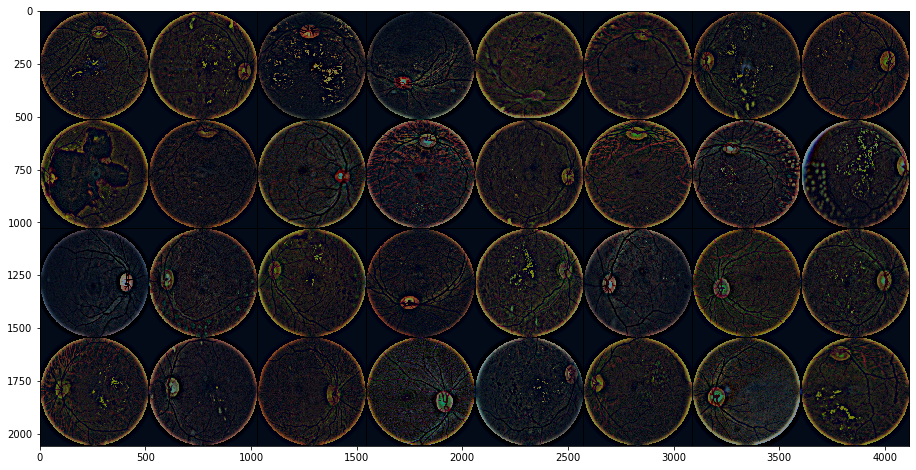

In [82]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
    


plt.figure(figsize=(16,8))
imshow(torchvision.utils.make_grid(batch_x))

## Add deformations!

```














```
# Train

In [14]:
from tensorboardX import SummaryWriter
from torch.optim import lr_scheduler

#### Change linear to our case

In [21]:
model.fc = torch.nn.Linear(2048,5)

In [52]:
params = []
for p in model.parameters():
    p.requires_grad = False
for name, m in model.named_modules():
    if name == 'layer4.2' or name == 'fc':
        for p_name, p in m.named_parameters():
            p.requires_grad = True
            params.append(p)
            print(name+"."+p_name)

layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [73]:
opt = torch.optim.Adam(params=params, lr = 0.0005)
writer = SummaryWriter("../logs")
device = torch.device('cuda')
model = model.to(device=device)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [22]:
!nvidia-smi

Sat Jul 27 20:31:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:05:00.0  On |                  N/A |
| 25%   35C    P8     9W / 250W |  10926MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 20%   43C    P8     8W / 250W |    149MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [74]:
num_iter = 5000

In [29]:
# def compute_loss(batch_x, batch_y):
#     logits = model(batch_x)
#     return F.cross_entropy(logits, batch_y).mean()



# def train(num_iter, train_iter, val_iter):
#     for i in range(num_iter):
#         model.train()
#         try:
#             batch_x, batch_y = train_iter.next()
#         except StopIteration:
#             train_iter = iter(train_loader)
#             batch_x, batch_y = train_iter.next()
#         loss = compute_loss(batch_x, batch_y)
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#         writer.add_scalar('data/loss', loss, i)
#         if i%10 == 0:
#             model.eval()
#             try:
#                 batch_x, batch_y = val_iter.next()
#             except StopIteration:
#                 val_iter = iter(val_loader)
#                 batch_x, batch_y = val_iter.next()
#             acc = float((model(batch_x).argmax(1) == batch_y).sum())/len(batch_y)
#             writer.add_scalar('data/test_accuracy', acc, i)
#         if i%100 == 0:
#             print('iteration ' + str(i))

In [ ]:
# train(num_iter, train_iter, val_iter)

iteration 0
iteration 100


In [ ]:
# submit = pd.read_csv('../Data/sample_submission.csv')

# def test(test_iter):
#     model.eval()
#     predicted = []
#     for i in range(len(test_iter)):
#         batch_x = test_iter.next()
#         score = model(batch_x)
#         label = score.argmax(1)
#         labels = label.tolist()
#         for lbl in labels:
#             predicted.append(str(lbl))
#     return predicted
        
        
# predicted = test(test_iter)

# submit['diagnosis'] = predicted
# submit.to_csv('submission.csv', index=False)
# submit.head()

```






```
# Regression train

In [15]:
from tensorboardX import SummaryWriter

model.fc = torch.nn.Linear(2048,1)

In [16]:
params = []
for p in model.parameters():
    p.requires_grad = False
for name, m in model.named_modules():
    if name == 'layer4.2' or name == 'fc':
        for p_name, p in m.named_parameters():
            p.requires_grad = True
            params.append(p)
            print(name+"."+p_name+"        "+str(p.shape))

layer4.2.conv1.weight        torch.Size([512, 2048, 1, 1])
layer4.2.bn1.weight        torch.Size([512])
layer4.2.bn1.bias        torch.Size([512])
layer4.2.conv2.weight        torch.Size([512, 512, 3, 3])
layer4.2.bn2.weight        torch.Size([512])
layer4.2.bn2.bias        torch.Size([512])
layer4.2.conv3.weight        torch.Size([2048, 512, 1, 1])
layer4.2.bn3.weight        torch.Size([2048])
layer4.2.bn3.bias        torch.Size([2048])
fc.weight        torch.Size([1, 2048])
fc.bias        torch.Size([1])


In [20]:
lr = 0.0005

opt = torch.optim.Adam(params=params, lr = lr)
writer = SummaryWriter("../logs/"+str(lr))
device = torch.device('cuda')
model = model.to(device=device)
model.train()
num_iter = 5000

In [21]:
def compute_loss(batch_x, batch_y):
    logits = model(batch_x).squeeze()
    return torch.mean((logits - batch_y.to(dtype=torch.float))**2)



def train(num_iter, train_iter):
    for i in range(num_iter):
        model.train()
        try:
            batch_x, batch_y = train_iter.next()
        except StopIteration:
            train_iter = iter(train_loader)
            batch_x, batch_y = train_iter.next()
        loss = compute_loss(batch_x, batch_y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        writer.add_scalar('data/loss', loss, i)
        if i%10 == 0:
            model.eval()
            acc = float( (torch.round(model(batch_x)[:,0]) == batch_y.to(dtype=torch.float)).sum())/len(batch_y)
            writer.add_scalar('data/train_accuracy', acc, i)
        if i%100 == 0:
            print('iteration ' + str(i))

In [22]:
train(num_iter, train_iter)

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900
iteration 2000
iteration 2100
iteration 2200
iteration 2300
iteration 2400
iteration 2500
iteration 2600
iteration 2700
iteration 2800
iteration 2900
iteration 3000
iteration 3100
iteration 3200
iteration 3300
iteration 3400
iteration 3500
iteration 3600
iteration 3700
iteration 3800
iteration 3900
iteration 4000
iteration 4100
iteration 4200
iteration 4300
iteration 4400
iteration 4500
iteration 4600
iteration 4700
iteration 4800
iteration 4900


In [23]:
torch.save(model.state_dict(), 'data2019_circle_crop_regression_aligned_classes_5000.state_dict')

```





```

In [18]:
# model.load_state_dict(torch.load('data2019_circle_crop_regression_5000.state_dict'))

In [101]:
model(batch_x)[:,0]

tensor([2.1580, 2.2022, 2.1537, 2.1654, 2.1837, 2.1621, 2.1818, 2.1780, 2.1853,
        2.1537, 2.1360, 2.1487, 2.1705, 2.1344, 2.1668, 2.1670, 2.1737, 2.1704,
        2.1674, 2.1746, 2.1354, 2.1736, 2.1584, 2.1862, 2.1510, 2.1795, 2.1806,
        2.1901, 2.1581, 2.2007, 2.1954, 2.1582], device='cuda:0',
       grad_fn=<SelectBackward>)

In [131]:
batch_y

tensor([2, 3, 3, 3, 4, 4, 3, 1, 4, 1, 0, 4, 4, 1, 4, 4, 0, 4, 4, 2, 2, 2, 0, 4,
        3, 2, 2, 0, 4, 4, 0, 4], device='cuda:0')

In [28]:
(model(batch_x)[:,0]*5).to(dtype=torch.long)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')